In [2]:
# pip install mplcyberpunk

Note: you may need to restart the kernel to use updated packages.


In [3]:
### Libraries for Machine Learning
import pandas as pd
import numpy as np
import statistics as stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import mplcyberpunk

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, accuracy_score
from statsmodels.stats import anova
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

In [4]:
df = pd.read_csv('CombinedCyclePowerPlant.csv', sep=',')
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


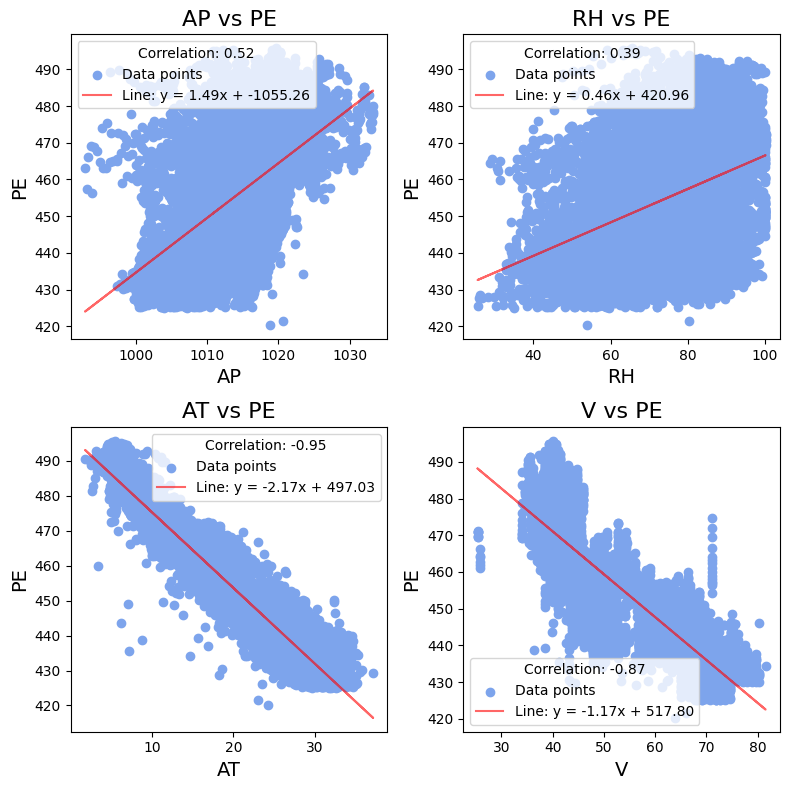

In [5]:
# Define the independent variables
independent_vars = ['AP', 'RH', 'AT', 'V']
y_name = 'PE'

# Create a figure for all plots
plt.figure(figsize=(8, 8)) # (height, width)

# Loop through independent variables and create plots
for i, x_name in enumerate(independent_vars):
    plt.subplot(2, 2, i + 1)  # 2x2 grid of plots
    x = df[x_name]
    y = df[y_name]
    
    plt.scatter(x, y, color='#7da4ec', label='Data points')
    
    # Fit a linear regression line (y = mx + b)
    m, b = np.polyfit(x, y, 1)
    
    # Plot the regression line
    plt.plot(x, m*x + b, color='red', alpha=0.6, label=f'Line: y = {m:.2f}x + {b:.2f}')
    
    # Calculate correlation
    correlation = np.corrcoef(x, y)[0, 1]
    
    # Add the correlation value to the legend
    plt.legend(title=f'Correlation: {correlation:.2f}')
    
    # Add labels and title
    plt.xlabel(x_name, size=14)
    plt.ylabel(y_name, size=14)
    plt.title(f'{x_name} vs {y_name}', size=16)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

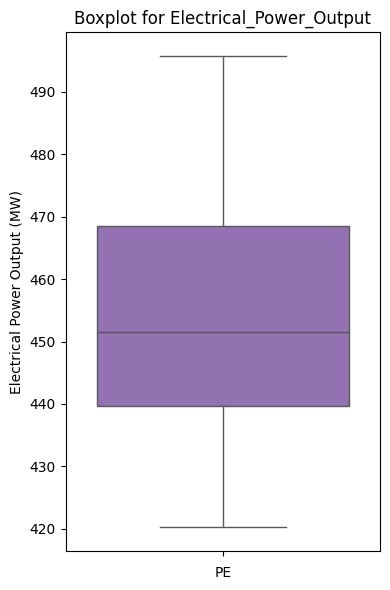

In [6]:
#Normal PE boxplot
df.columns=['Ambient_Temperature','Vacuum','Atmospheric_Pressure','Relative_Humidity','Electrical_Power_Output']
plt.figure(figsize=(4, 6))
sns.boxplot(y=df['Electrical_Power_Output'], color='#9467bd') 
plt.title(f'Boxplot for Electrical_Power_Output')
plt.xlabel('PE')
plt.ylabel('Electrical Power Output (MW)')
plt.tight_layout()
plt.show()

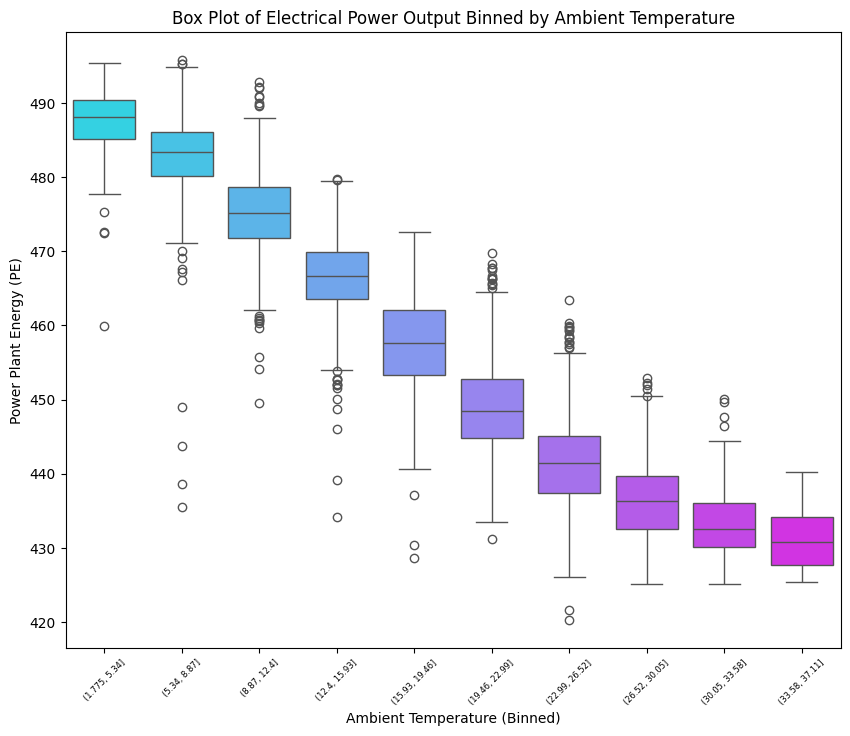

In [7]:
# Create a copy of the original df to avoid altering it
binned_df = df.copy()
binned_df['Ambient_Temperature_bin'] = pd.cut(binned_df['Ambient_Temperature'], bins=10)

# Plot PE vs binned AT
plt.figure(figsize=(10, 8))
sns.boxplot(x='Ambient_Temperature_bin', y='Electrical_Power_Output', data=binned_df, palette='cool', hue='Ambient_Temperature_bin', legend=False)
plt.title('Box Plot of Electrical Power Output Binned by Ambient Temperature')
plt.xlabel('Ambient Temperature (Binned)')
plt.ylabel('Power Plant Energy (PE)')
plt.xticks(rotation=45, size=6)
plt.show()

# Outlier remove function

In [8]:
# Function to remove outliers from target var, based on feature
def remove_outliers(df, feature, target):
    # Define Q1,Q3,IQR
    Q1 = df.groupby(feature, observed=False)[target].quantile(0.25)
    Q3 = df.groupby(feature, observed=False)[target].quantile(0.75)
    IQR = Q3 - Q1
    # Define lower and upper limit for removal, adjust scale factor integer as needed
    # Using a scale factor (like IQR) allows for adjustment based on the dataset's characteristics,
    # making the outlier detection process more flexible and context-sensitive
    lower_bound = Q1 - 1.0 * IQR
    upper_bound = Q3 + 1.0 * IQR
    # Merge bounds to original dataframe
    bounds_df = pd.DataFrame({'lower_bound': lower_bound, 'upper_bound': upper_bound})
    df = df.merge(bounds_df, how='left', left_on=feature, right_index=True)
    # Outlier index tracking
    outlier_indices = df[(df[target] < df['lower_bound']) | (df[target] > df['upper_bound'])].index
    # Make dataframe without outliers, keep less than upper and above lower bounds
    df_filtered = df[(df[target] >= df['lower_bound']) & (df[target] <= df['upper_bound'])]
    # Drop the columns with bounds
    df_filtered = df_filtered.drop(['lower_bound', 'upper_bound'], axis=1)

    return df_filtered, outlier_indices

# Bin and remove outliers

In [9]:
######### start of Bin and remove outliers

# Create a copy of the original df to avoid altering it
binned_df = df.copy()

# Feature bin creation in the new dataframe
binned_df['Ambient_Temperature_bin'] = pd.cut(binned_df['Ambient_Temperature'], bins=10)
binned_df['Relative_Humidity_bin'] = pd.cut(binned_df['Relative_Humidity'], bins=10)
binned_df['Atmospheric_Pressure_bin'] = pd.cut(binned_df['Atmospheric_Pressure'], bins=10)
binned_df['Vacuum_bin'] = pd.cut(binned_df['Vacuum'], bins=10)

# List of binned features
binned_features = ['Atmospheric_Pressure_bin', 'Relative_Humidity_bin', 'Ambient_Temperature_bin', 'Vacuum_bin']

df_outliers_removed = binned_df.copy() # copy binned df to remove outliers from
removed_indices = [] # Set an empty list for removed_indices before adding to list

# Apply outlier_removal() to each binned feature
for feature in binned_features:
    df_outliers_removed, outliers = remove_outliers(df_outliers_removed, feature, 'Electrical_Power_Output')
    removed_indices.extend(outliers.tolist())

# Outlier and index checks
print(f"Count of total removed binned PE outliers: {len(removed_indices)}")
remaining_indices = set(removed_indices).intersection(df_outliers_removed.index)
if remaining_indices:
    print(f"Original binned PE outliers remaining after removal: {list(remaining_indices)}")
else:
    print("No original binned PE outliers remaining.")

######### end of Bin and remove outliers

Count of total removed binned PE outliers: 1256
No original binned PE outliers remaining.


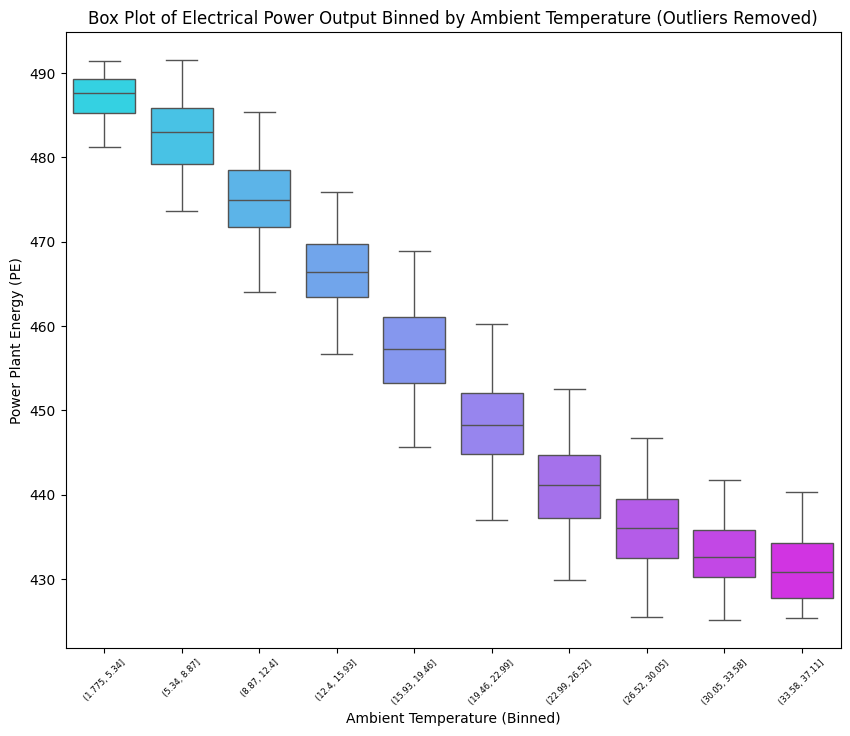

In [10]:
# Create a copy of the df_outliers_removed to avoid altering it
binned_df = df_outliers_removed.copy()
binned_df['Ambient_Temperature_bin'] = pd.cut(binned_df['Ambient_Temperature'], bins=10)

plt.figure(figsize=(10, 8))

# Corrected line: Removed brackets around 'Ambient_Temperature_bin'
sns.boxplot(x='Ambient_Temperature_bin', y='Electrical_Power_Output', data=binned_df, palette='cool',hue='Ambient_Temperature_bin', legend=False)

plt.title('Box Plot of Electrical Power Output Binned by Ambient Temperature (Outliers Removed)')
plt.xlabel('Ambient Temperature (Binned)')
plt.ylabel('Power Plant Energy (PE)')
plt.xticks(rotation=45, size=6)
plt.show()

VIF$(X_i)$=1 / 1- $R_i^{2}$

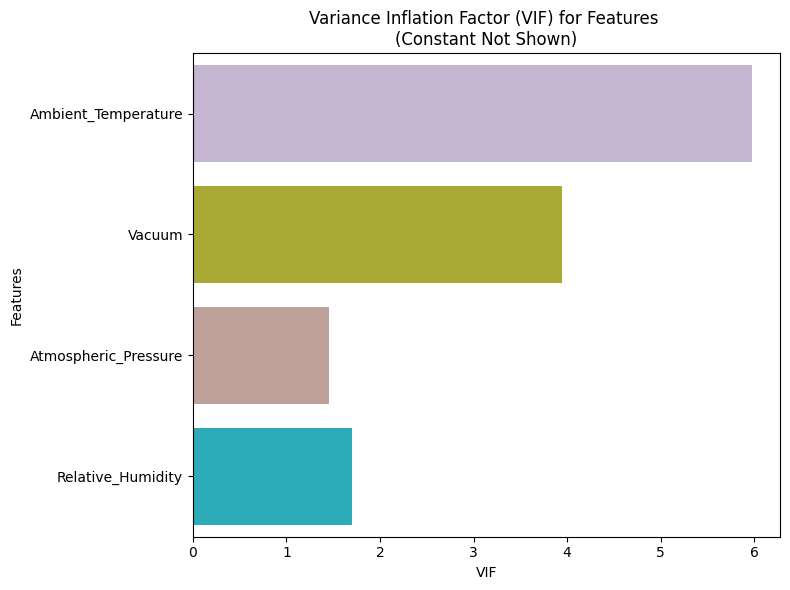

In [11]:
# Define feature variables (AP, RH, AT, V)
X = df[['Ambient_Temperature','Vacuum','Atmospheric_Pressure','Relative_Humidity']]

# Add a constant for the intercept in the linear regression
X = sm.add_constant(X)
y = df['Electrical_Power_Output']
# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out the constant from the DataFrame
vif = vif[vif["Feature"] != "const"]

# Plot VIF values as a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='VIF', y='Feature', data=vif,palette='tab20',hue=y,legend=False)
plt.title("Variance Inflation Factor (VIF) for Features \n(Constant Not Shown)")
plt.xlabel("VIF")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

                      Ambient_Temperature    Vacuum  Atmospheric_Pressure  \
Ambient_Temperature              1.000000  0.844107             -0.507549   
Vacuum                           0.844107  1.000000             -0.413502   
Atmospheric_Pressure            -0.507549 -0.413502              1.000000   
Relative_Humidity               -0.542535 -0.312187              0.099574   

                      Relative_Humidity  
Ambient_Temperature           -0.542535  
Vacuum                        -0.312187  
Atmospheric_Pressure           0.099574  
Relative_Humidity              1.000000  


,VIF Factor,features
0,39.157705,Ambient_Temperature
1,74.969127,Vacuum
2,66.618618,Atmospheric_Pressure
3,40.704756,Relative_Humidity


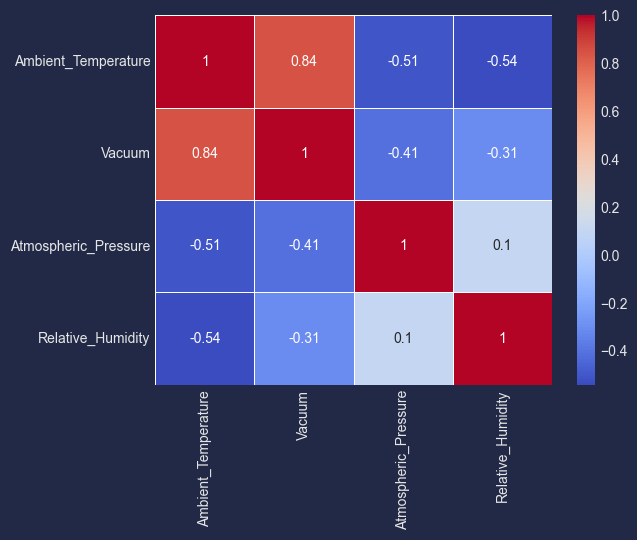

In [15]:
### Check the Correlation between the features
df_features=df.drop('Electrical_Power_Output',axis=1)
print(df_features.corr())
sns.heatmap(df_features.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
###  check the VIF (Variance Inflation Factor) of the features
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

#### VIF between the features dropping V
# X = df_features.drop('V',axis=1)
X=df_features
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif
    

In [12]:
############################################################################################################
#
#   Base Class for the Model
#
############################################################################################################
class Model:
    def __init__(self,X,y,test_size=0.2,random_state=42,val_size=0.25,model="LinearRegression"):
        '''
        Parameters:
        X: Features
        y: Target
        test_size: Test size
        random_state: Random state
        val_size: Validation size
        model: Model to be used
        '''
        self.model_name = model
        self.models = {
            "LinearRegression": {
                "model": lambda X, y: LinearRegression(),
                "fit": lambda X, y: self.model.fit(X, y)
            },
            "OLS": {
                "model":lambda X, y: sm.OLS(y, X),
                "fit": lambda X, y: self.model.fit()
            },
            "DecisionTreeRegressor": {
                "model": lambda X, y: DecisionTreeRegressor(),
                "fit": lambda X, y: self.model.fit(X, y)
            },
            "RandomForestRegressor": {
                "model": lambda X, y: RandomForestRegressor(),
                "fit": lambda X, y: self.model.fit(X, y)
            },
            "GradientBoostingRegressor": {
                "model": lambda X, y: GradientBoostingRegressor(),
                "fit": lambda X, y: self.model.fit(X, y)
            },
            "AdaBoostRegressor": {
                "model": lambda X, y: AdaBoostRegressor(),
                "fit": lambda X, y: self.model.fit(X, y)
            },
            "BaggingRegressor": {
                "model": lambda X, y: BaggingRegressor(),
                "fit": lambda X, y: self.model.fit(X, y)
            },
            "SVR": {
                "model": lambda X, y: SVR(),
                "fit": lambda X, y: self.model.fit(X, y)
            }
            ,
            "MLPRegressor": {
                "model": lambda X, y: MLPRegressor(),
                "fit": lambda X, y: self.model.fit(X, y)
            }
        }
        self.X = X
        self.y = y
        self.test_size = test_size
        self.random_state = random_state
        self.val_size = val_size
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=self.test_size, random_state=self.random_state)
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=self.val_size, random_state=self.random_state)
        self.model = self.models[self.model_name]['model'](self.X_train, self.y_train)

    @staticmethod
    def get_models():
        return ["LinearRegression", "OLS","DecisionTreeRegressor", "RandomForestRegressor", "GradientBoostingRegressor", "AdaBoostRegressor", "BaggingRegressor", "SVR", "MLPRegressor"]

    def train(self):
        self.model=self.models[self.model_name]['fit'](self.X_train, self.y_train)
        return self.evaluate(self.X_train, self.y_train)

    def predict(self, X):
        return self.model.predict(X)
    
    def validate(self):
        return self.evaluate(self.X_val, self.y_val)
    
    def test(self):
        return self.evaluate(self.X_test, self.y_test)

    def evaluate(self, X, y):
        y_pred = self.predict(X)
        mse = mean_squared_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        return np.round((mse, mae, r2), decimals=2)
    
    def summary(self):
        return self.model.summary()
    
    def plotResiduals(self, X, y):
        residuals = y - self.predict(X)
        sns.scatterplot(x=self.predict(X), y=residuals)
        plt.xlabel('Predictions')
        plt.ylabel('Residuals')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Residuals vs. Predictions')
        plt.show()

    def plot_residuals(self):
        self.plotResiduals(self.X_val, self.y_val)
    
    def plot_residuals_test(self):
        self.plotResiduals(self.X_test, self.y_test)

    def plot_residuals_val(self):
        self.plotResiduals(self.X_val, self.y_val)


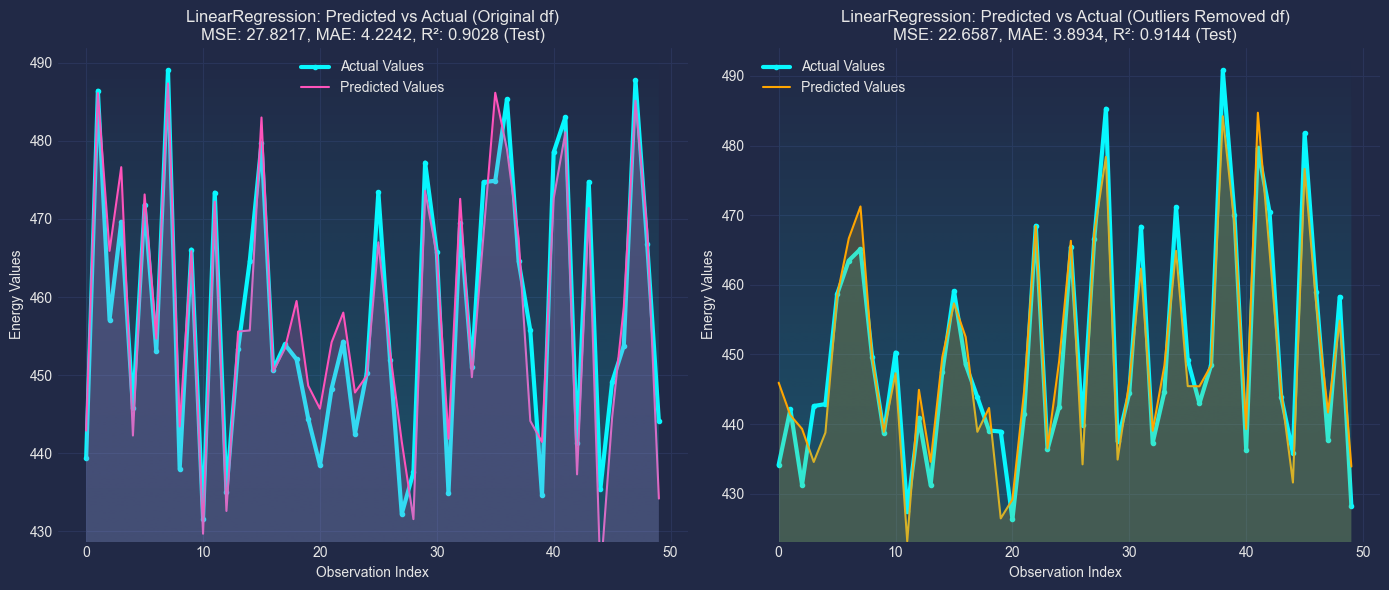

In [16]:
# Limit observations to plot (test set for plot)
start_obs = 100
end_obs = 150

# Set random seed for reproducibility
np.random.seed(42)
plt.style.use("cyberpunk")

# Features (X) and target (y) - Original df
X = df[['Ambient_Temperature', 'Atmospheric_Pressure']]
y = df['Electrical_Power_Output']

# First split: training + test sets (original df)
# Test size: 20%, training size: 80%
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: training into training + validation sets (original df)
# split 80% training into 64% training and 16% validation.
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Initialize and fit the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set (original df)
y_test_predictions = model.predict(X_test)

# Calculate performance metrics on the test set
mse_test = mean_squared_error(y_test, y_test_predictions)
mae_test = mean_absolute_error(y_test, y_test_predictions)
r2_test = r2_score(y_test, y_test_predictions)

# Now for the outliers removed DataFrame (df_outliers_removed)
# Features (X) and target (y) - Outliers removed
X_outliers = df_outliers_removed[['Ambient_Temperature', 'Atmospheric_Pressure']]
y_outliers = df_outliers_removed['Electrical_Power_Output']

# Train-test split for outliers removed
X_train_full_outliers, X_test_outliers, y_train_full_outliers, y_test_outliers = train_test_split(X_outliers, y_outliers, test_size=0.2, random_state=42)
X_train_outliers, X_val_outliers, y_train_outliers, y_val_outliers = train_test_split(X_train_full_outliers, y_train_full_outliers, test_size=0.2, random_state=42)

# Initialize and fit the Linear Regression model on outliers removed
model_outliers = LinearRegression()
model_outliers.fit(X_train_outliers, y_train_outliers)

# Make predictions on the test set (outliers removed)
y_test_predictions_outliers = model_outliers.predict(X_test_outliers)

# Calculate performance metrics on the test set for outliers removed
mse_test_outliers = mean_squared_error(y_test_outliers, y_test_predictions_outliers)
mae_test_outliers = mean_absolute_error(y_test_outliers, y_test_predictions_outliers)
r2_test_outliers = r2_score(y_test_outliers, y_test_predictions_outliers)

# Create side-by-side plots
plt.figure(figsize=(14, 6))

# Selecting part of the data for plotting (original df)
predictions_num = y_test_predictions[start_obs:end_obs]
y_test_num = y_test.iloc[start_obs:end_obs]
x_values_num = np.arange(len(predictions_num))

# Selecting part of the data for plotting (outliers removed)
predictions_num_outliers = y_test_predictions_outliers[start_obs:end_obs]
y_test_num_outliers = y_test_outliers.iloc[start_obs:end_obs]

# Plot for original df
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(x_values_num, y_test_num, linewidth=3, marker='.', label='Actual Values')
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.2, gradient_start='top')  # underglow specs
plt.plot(x_values_num, predictions_num, linewidth=1.5, label='Predicted Values')
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.2, gradient_start='zero')  # underglow specs
plt.title(f'LinearRegression: Predicted vs Actual (Original df)\n'
          f'MSE: {mse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f} (Test)')
plt.xlabel('Observation Index')
plt.ylabel('Energy Values')
plt.legend()
plt.tight_layout()

# Plot for df_outliers_removed
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(x_values_num, y_test_num_outliers, linewidth=3, marker='.', label='Actual Values')
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.2, gradient_start='top')  # underglow specs
plt.plot(x_values_num, predictions_num_outliers, linewidth=1.5, label='Predicted Values', color='orange')
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.2, gradient_start='zero')  # underglow specs
plt.title(f'LinearRegression: Predicted vs Actual (Outliers Removed df)\n'
          f'MSE: {mse_test_outliers:.4f}, MAE: {mae_test_outliers:.4f}, R²: {r2_test_outliers:.4f} (Test)')
plt.xlabel('Observation Index')
plt.ylabel('Energy Values')
plt.legend()
plt.tight_layout()

# Show the plots
plt.show()


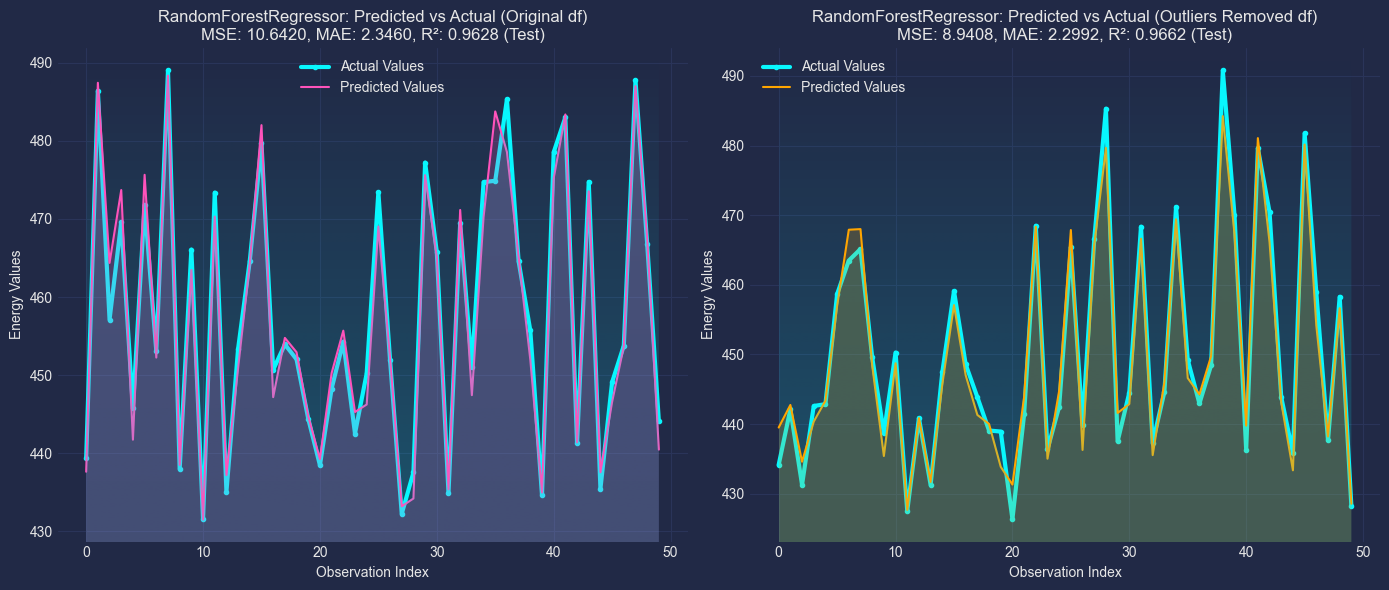

In [14]:
# Limit observations to plot (test set for plot)
start_obs = 100
end_obs = 150

# Set random seed for reproducibility
np.random.seed(42)
plt.style.use("cyberpunk")

# Features (X) and target (y) - Original df
X = df[['Ambient_Temperature', 'Atmospheric_Pressure', 'Relative_Humidity','Vacuum']]
y = df['Electrical_Power_Output']

# First split: training + test sets (original df)
# Test size: 20%, training size: 80%
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: training into training + validation sets (original df)
# split 80% training into 64% training and 16% validation.
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Initialize and fit the Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set (original df)
y_test_predictions = model.predict(X_test)

# Calculate performance metrics on the test set
mse_test = mean_squared_error(y_test, y_test_predictions)
mae_test = mean_absolute_error(y_test, y_test_predictions)
r2_test = r2_score(y_test, y_test_predictions)

# Now for the outliers removed DataFrame (df_outliers_removed)
# Features (X) and target (y) - Outliers removed
X_outliers = df_outliers_removed[['Ambient_Temperature', 'Atmospheric_Pressure', 'Relative_Humidity','Vacuum']]
y_outliers = df_outliers_removed['Electrical_Power_Output']

# Train-test split for outliers removed
X_train_full_outliers, X_test_outliers, y_train_full_outliers, y_test_outliers = train_test_split(X_outliers, y_outliers, test_size=0.2, random_state=42)
X_train_outliers, X_val_outliers, y_train_outliers, y_val_outliers = train_test_split(X_train_full_outliers, y_train_full_outliers, test_size=0.2, random_state=42)

# Initialize and fit the Random Forest model on outliers removed
model_outliers = RandomForestRegressor(random_state=42)
model_outliers.fit(X_train_outliers, y_train_outliers)

# Make predictions on the test set (outliers removed)
y_test_predictions_outliers = model_outliers.predict(X_test_outliers)

# Calculate performance metrics on the test set for outliers removed
mse_test_outliers = mean_squared_error(y_test_outliers, y_test_predictions_outliers)
mae_test_outliers = mean_absolute_error(y_test_outliers, y_test_predictions_outliers)
r2_test_outliers = r2_score(y_test_outliers, y_test_predictions_outliers)

# Create side-by-side plots
plt.figure(figsize=(14, 6))

# Selecting part of the data for plotting (original df)
predictions_num = y_test_predictions[start_obs:end_obs]
y_test_num = y_test.iloc[start_obs:end_obs]
x_values_num = np.arange(len(predictions_num))

# Selecting part of the data for plotting (outliers removed)
predictions_num_outliers = y_test_predictions_outliers[start_obs:end_obs]
y_test_num_outliers = y_test_outliers.iloc[start_obs:end_obs]

# Plot for original df
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(x_values_num, y_test_num, linewidth=3, marker='.', label='Actual Values')
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.2, gradient_start='top')  # underglow specs
plt.plot(x_values_num, predictions_num, linewidth=1.5, label='Predicted Values')
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.2, gradient_start='zero')  # underglow specs
plt.title(f'RandomForestRegressor: Predicted vs Actual (Original df)\n'
          f'MSE: {mse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f} (Test)')
plt.xlabel('Observation Index')
plt.ylabel('Energy Values')
plt.legend()
plt.tight_layout()

# Plot for df_outliers_removed
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(x_values_num, y_test_num_outliers, linewidth=3, marker='.', label='Actual Values')
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.2, gradient_start='top')  # underglow specs
plt.plot(x_values_num, predictions_num_outliers, linewidth=1.5, label='Predicted Values', color='orange')
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.2, gradient_start='zero')  # underglow specs
plt.title(f'RandomForestRegressor: Predicted vs Actual (Outliers Removed df)\n'
          f'MSE: {mse_test_outliers:.4f}, MAE: {mae_test_outliers:.4f}, R²: {r2_test_outliers:.4f} (Test)')
plt.xlabel('Observation Index')
plt.ylabel('Energy Values')
plt.legend()
plt.tight_layout()

# Show the plots
plt.show()
